# Convolution Image Net

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.nn_graph import simple_layer
from utils.data import init_dir

## Load data

In [5]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Conv Net Graph

In [6]:
from utils.nn_visualization import conv33132_summaries, conv55124_summary, variable_summaries

In [7]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('conv_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        #########################################################
        # Add dropout and batch normalization control variables #
        #########################################################
            
    with tf.name_scope('image_reshape'):        
        images_reshaped = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv_layer_1'):
        pass
        ##############################################################
        # Fill in conv layer, 32 filter 3*3 with relu and maxpooling #
        ##############################################################

    with tf.variable_scope('conv_layer_2'):
        pass
        ##############################################################
        # Fill in conv layer, 64 filter 3*3 with relu and maxpooling #
        ##############################################################
    
    with tf.variable_scope('feed_forward_layer_1'):
        raw_prediction = tf.reshape(images_reshaped, [-1, 28 * 28])
        raw_prediction = simple_layer('ff_1', raw_prediction, shape=[28 * 28, 10], activation='linear')
        ###############
        # Add dropout #
        ###############
    
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.variable_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)

    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=raw_prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)
        
    with tf.name_scope('training'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_step  = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)
    
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [8]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/conv_image_net/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Add Embedding Projection

In [9]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data
from utils.nn_visualization import get_sprite_img, get_label_class_names

sprite_img = get_sprite_img(data.validation.images, img_shape)
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Conv Net

In [11]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']

        
validation_feed_dict = {
    images: data.validation.images, 
    labels: data.validation.labels}

with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(5000):
        _images, _labels = data.train.next_batch(100)
        
        feed_dict={images: _images, 
                   labels: _labels}
        _ = session.run([train_step], feed_dict)
        

        if iteration % 10 == 0:
            feed_dict={images: _images, 
                       labels: _labels}
            _summary, = session.run([merge_summaries], feed_dict)
            logging_meta['train_writer'].add_summary(_summary, iteration)
            
        if iteration % 100 == 0:
            fetches = [embedding_assignment, merge_summaries, accuracy, loss]
            _, _summary, _accuracy, _loss = session.run(fetches, validation_feed_dict)
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], validation_feed_dict)

Iteration 0: loss 2.495741844177246, accuracy 0.09920000284910202
Iteration 100: loss 1.8056066036224365, accuracy 0.4490000009536743
Iteration 200: loss 1.4447932243347168, accuracy 0.6208000183105469
Iteration 300: loss 1.2359941005706787, accuracy 0.6615999937057495
Iteration 400: loss 1.1048904657363892, accuracy 0.6854000091552734
Iteration 500: loss 1.017450213432312, accuracy 0.6966000199317932
Iteration 600: loss 0.9535505771636963, accuracy 0.70660001039505
Iteration 700: loss 0.9033926725387573, accuracy 0.7184000015258789
Iteration 800: loss 0.8641414046287537, accuracy 0.7314000129699707
Iteration 900: loss 0.8313774466514587, accuracy 0.7376000285148621
Iteration 1000: loss 0.8041993975639343, accuracy 0.7491999864578247
Iteration 1100: loss 0.7794439792633057, accuracy 0.7544000148773193
Iteration 1200: loss 0.7600021362304688, accuracy 0.760200023651123
Iteration 1300: loss 0.7420634031295776, accuracy 0.7627999782562256
Iteration 1400: loss 0.7268334627151489, accuracy 

## Results evaluation

In [12]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [14]:
df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, data.validation.images)

In [15]:
get_accuracy(df)

82.78

In [16]:
get_accuracy(df, True)

97.82

In [17]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,74.80,82.49
1,Trouser,95.96,94.06
2,Pullover,72.17,72.02
3,Dress,83.21,87.03
4,Coat,70.46,78.69
5,Sandal,93.89,84.18
6,Shirt,68.52,49.90
7,Sneaker,87.55,91.99
8,Bag,90.10,94.69
9,Ankle boot,87.62,90.91


In [18]:
fp = get_false_positives(df, 'Shirt')

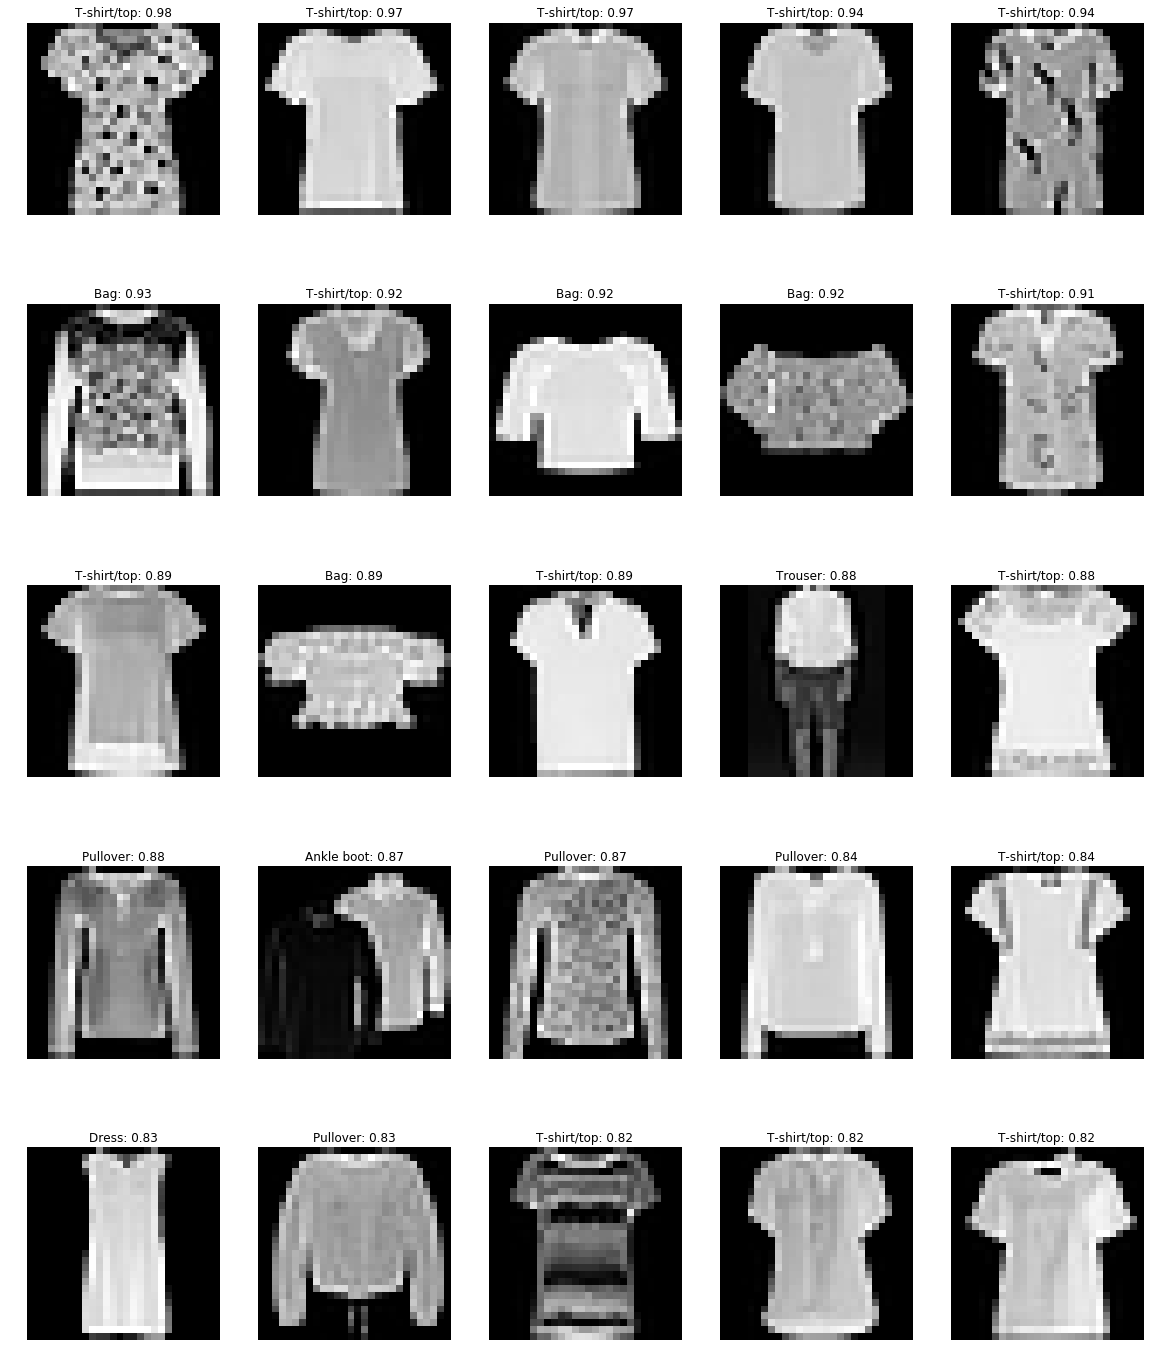

In [19]:
plot_examples(fp)

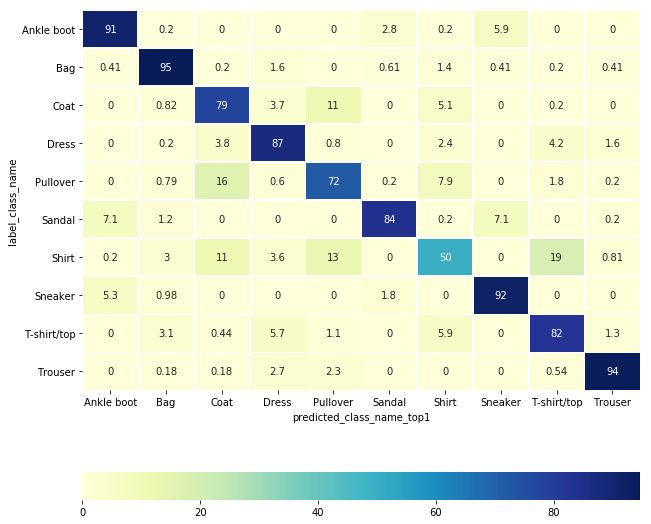

In [20]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)